# TEST THE TRAINED WEIGHTS ON UNSEEEN DATA

In [3]:
import matplotlib.pyplot as plt
import torchvision
import seaborn as sns
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import cv2
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix, classification_report as skl_classification_report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score



# Performance testing
1. Define the Model Architecture

In [4]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet model
model = models.resnet152(pretrained=True)

# Modify the final layer
num_ftrs = model.fc.in_features
out_ftrs = 2  # Binary classification
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512, out_ftrs),
    nn.LogSoftmax(dim=1)
)

# Move the model to the device
model.to(device)


/home/thembo/college/cataract/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/thembo/college/cataract/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

2. Load the Model Weights

In [3]:
# Load the model state
model.load_state_dict(torch.load('final_model.pth'))

# Ensure the model is in evaluation mode
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

3. Create dataset and loader

In [5]:
# Custom Dataset Class
class CataractDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if idx >= len(self.data):
            # Return placeholder data when index is out of bounds
            return self.get_placeholder_data()
        
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        try:
            image = Image.open(img_name).convert('RGB')
            label = int(self.data.iloc[idx, 1])
            if label not in [0, 1]:
                raise ValueError("Invalid label")
        except Exception as e:
            print(f"Warning: {e}. Using a blank image.")
            image = Image.new('RGB', (224, 224))
            label = 0  # Default label for blank image

        if self.transform:
            image = self.transform(image)

        return image, label
    def get_placeholder_data(self):
        # Return a blank image and a default label
        blank_image = Image.new('RGB', (224, 224), color='white')
        default_label = 0  # Default label
        if self.transform:
            blank_image = self.transform(blank_image)
        return blank_image, default_label

test_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create Dataset and DataLoader
test_dataset = CataractDataset(csv_file='test2.csv', root_dir='../test2', transform=test_transforms)

valid_size = 0.2
num_train = len(test_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

valid_sampler = SubsetRandomSampler(valid_idx)
testloader = DataLoader(test_dataset, batch_size=4, sampler=valid_sampler)

print(f'Testing examples: {len(test_dataset)}')

Testing examples: 500


4. Evaluate model

In [6]:
def evaluate_model(model, testloader):
    test_loss = 0
    accuracy = 0
    criterion = nn.NLLLoss()
    
    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            logps = model(images)
            test_loss += criterion(logps, labels)
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    test_loss = test_loss / len(testloader)
    accuracy = accuracy / len(testloader)
    print(f'Test Loss: {test_loss:.3f}.. Test Accuracy: {accuracy:.3f}')

# Evaluate the model
evaluate_model(model, testloader)


Test Loss: 0.148.. Test Accuracy: 0.950


# Result  interpretation

Test Loss (0.148): A lower loss indicates that the model's predictions are close to the actual labels.

Test Accuracy (0.950): This means that 95% of the predictions made by the model are correct. For binary classification, this is a strong indicator of good performance.

# Analyze Misclassifications

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1975338].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2914162].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..1.6057423].


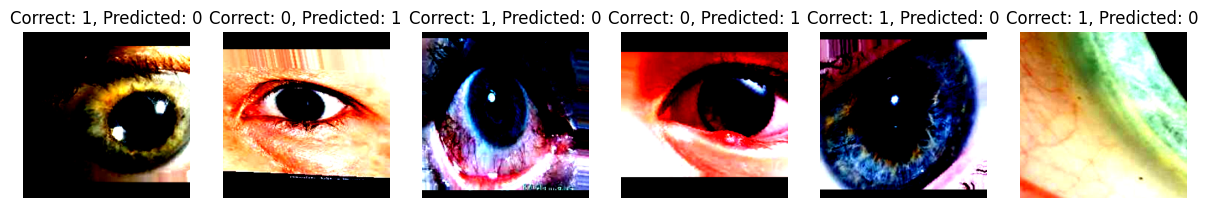

In [11]:
def analyze_misclassifications(model, testloader):
    misclassified_images = []
    correct_labels = []
    predicted_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            incorrect_idx = (predicted != labels).nonzero()
            for idx in incorrect_idx:
                misclassified_images.append(images[idx].cpu())
                correct_labels.append(labels[idx].cpu().item())
                predicted_labels.append(predicted[idx].cpu().item())

    return misclassified_images, correct_labels, predicted_labels

misclassified_images, correct_labels, predicted_labels = analyze_misclassifications(model, testloader)

# Visualize misclassified images
num_examples = len(misclassified_images)
fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
for i in range(num_examples):
    misclassified_image = misclassified_images[i].squeeze().permute(1, 2, 0)
    axes[i].imshow(misclassified_image)
    axes[i].set_title(f'Correct: {correct_labels[i]}, Predicted: {predicted_labels[i]}')
    axes[i].axis('off')
plt.show()

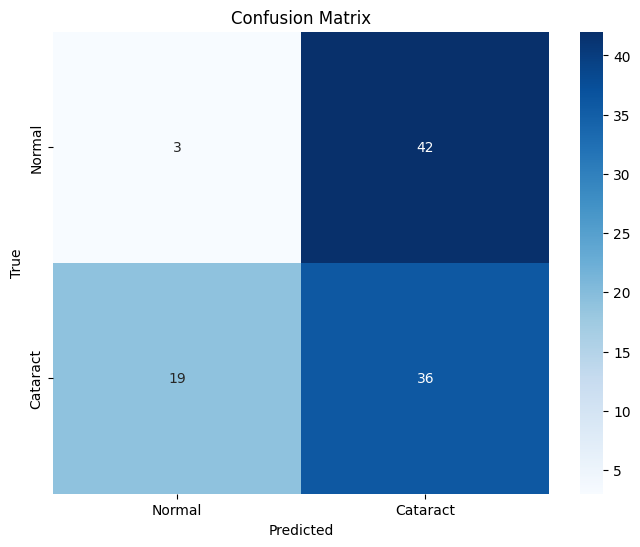

In [6]:
def plot_confusion_matrix(model, testloader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Cataract'], yticklabels=['Normal', 'Cataract'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, testloader)

# Optimize the model Size and Performance for mobile platforms
